In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import random
import pprint
pp = pprint.PrettyPrinter()
from torchsampler import ImbalancedDatasetSampler

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [2]:
dataset0_classes = os.listdir('dataset0/train/')
dataset0_label_encoder = LabelEncoder()

dataset0_label_encoder.fit(dataset0_classes)
print(dataset0_label_encoder.classes_)

dataset1_classes = os.listdir('dataset1/train/')
dataset1_label_encoder = LabelEncoder()

dataset1_label_encoder.fit(dataset1_classes)
print(dataset1_label_encoder.classes_)

['class0' 'class1' 'class11' 'class12' 'class13' 'class14' 'class15'
 'class2' 'class3' 'class4' 'class5' 'class6' 'class7' 'class8' 'class9']
['class0' 'class1' 'class10' 'class2' 'class3' 'class4' 'class5' 'class6'
 'class7' 'class8' 'class9']


In [3]:
dataset0_dir = 'dataset0/'
dataset1_dir = 'dataset1/'

dataset0_train_dir = dataset0_dir + 'train/'
dataset0_test_dir = dataset0_dir + 'test/'

dataset1_train_dir = dataset1_dir + 'train/'
dataset1_test_dir = dataset1_dir + 'test/'

In [4]:
def get_count(data_path):
    data_dict = dict()
    for cls in os.listdir(data_path):
        data_dict[cls] = len(os.listdir(os.path.join(data_path, cls)))
    data_dict = list(sorted(data_dict.items(), key = lambda item: item[1], reverse=True))
    key = [i[0][5:] for i in data_dict]
    value = [i[1] for i in data_dict]
    return data_dict, key, value

[('class1', 3504),
 ('class0', 3446),
 ('class4', 1098),
 ('class2', 1098),
 ('class6', 730),
 ('class15', 728),
 ('class5', 487),
 ('class9', 480),
 ('class8', 478),
 ('class12', 386),
 ('class14', 384),
 ('class13', 384),
 ('class11', 384),
 ('class3', 222),
 ('class7', 152)]


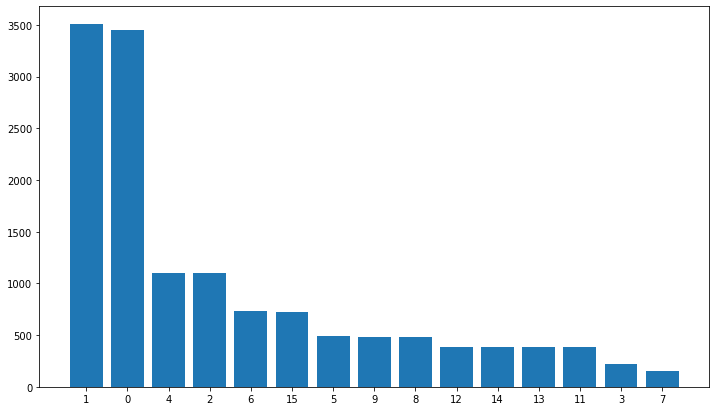

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(12,7))
data0_train, key, value = get_count(dataset0_train_dir)
pp.pprint(data0_train)
axes.bar(key, value)
plt.show()

[('class1', 1751),
 ('class0', 1723),
 ('class4', 549),
 ('class2', 549),
 ('class6', 365),
 ('class15', 364),
 ('class5', 243),
 ('class9', 240),
 ('class8', 238),
 ('class14', 192),
 ('class11', 192),
 ('class12', 192),
 ('class13', 191),
 ('class3', 110),
 ('class7', 76)]


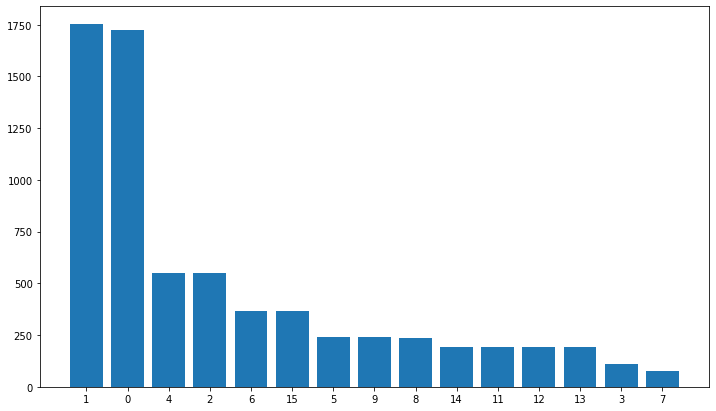

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(12,7))
data0_test, key, value = get_count(dataset0_test_dir)
pp.pprint(data0_test)
axes.bar(key, value)
plt.show()

[('class3', 686),
 ('class1', 333),
 ('class4', 307),
 ('class5', 152),
 ('class0', 85),
 ('class2', 49),
 ('class7', 48),
 ('class6', 36),
 ('class9', 24),
 ('class8', 24),
 ('class10', 6)]


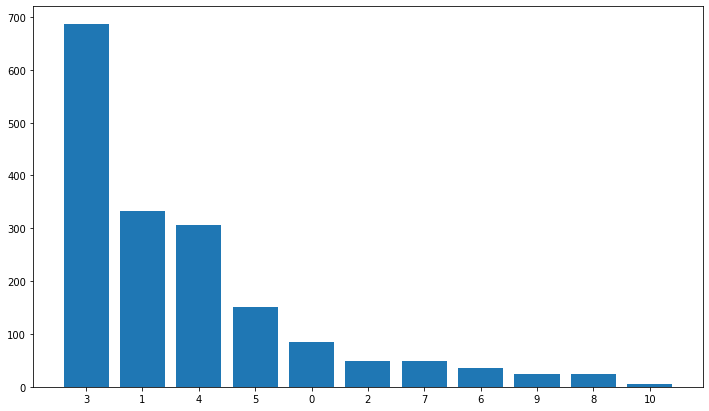

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(12,7))
data1_train, key, value = get_count(dataset1_train_dir)
pp.pprint(data1_train)
axes.bar(key, value)
plt.show()

In [8]:
batch_size = 256
epochs = 500
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [9]:
def create_dataset(dataset_dir):
  X, y = [], []
  labels = os.listdir(dataset_dir)
  for label in labels:
    file_list = os.listdir(dataset_dir + label + '/')
    for f in file_list:
      temp = pd.read_csv(dataset_dir + label + '/' + f)
      X.append(torch.from_numpy(temp.values))
      y.append(label)
  X = pad_sequence(X, batch_first=True)
  return X, y

In [10]:
# dataset0's training/test datasets & dataloader
dataset0_X_train, dataset0_y_train = create_dataset(dataset0_train_dir)
dataset0_y_train = dataset0_label_encoder.transform(dataset0_y_train)

dataset0_X_test, dataset0_y_test = create_dataset(dataset0_test_dir)
dataset0_y_test = dataset0_label_encoder.transform(dataset0_y_test)



In [11]:
dataset0_train_dataset = TensorDataset(torch.tensor(dataset0_X_train).float(), torch.from_numpy(dataset0_y_train))
dataset0_test_dataset = TensorDataset(torch.tensor(dataset0_X_test).float(), torch.from_numpy(dataset0_y_test))

dataset0_train_dataloader = DataLoader(dataset0_train_dataset,
                                       sampler=ImbalancedDatasetSampler(dataset0_train_dataset),
                                       batch_size=batch_size)
dataset0_test_dataloader= DataLoader(dataset0_test_dataset,
                                     batch_size=batch_size)

/tmp/ipykernel_24203/2143072385.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset0_train_dataset = TensorDataset(torch.tensor(dataset0_X_train).float(), torch.from_numpy(dataset0_y_train))
/tmp/ipykernel_24203/2143072385.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset0_test_dataset = TensorDataset(torch.tensor(dataset0_X_test).float(), torch.from_numpy(dataset0_y_test))


In [12]:
# dataset1's training datasets & dataloader
dataset1_X_train, dataset1_y_train = create_dataset(dataset1_train_dir)
dataset1_y_train = dataset1_label_encoder.transform(dataset1_y_train)

dataset1_train_dataset = TensorDataset(torch.tensor(dataset1_X_train).float(), torch.from_numpy(dataset1_y_train))
dataset1_train_dataloader = DataLoader(dataset1_train_dataset,
                                       sampler=ImbalancedDatasetSampler(dataset1_train_dataset),
                                       batch_size=batch_size)

/tmp/ipykernel_24203/3370797675.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset1_train_dataset = TensorDataset(torch.tensor(dataset1_X_train).float(), torch.from_numpy(dataset1_y_train))


In [13]:
"""
해당 셀의 코드 중 dataloader 부분의 `shuffle=False` 는 수정하면 안됩니다.
"""

dataset1_test_X = []
test_list = os.listdir(dataset1_test_dir)
for f in test_list:
  temp = pd.read_csv(dataset1_test_dir + f)
  dataset1_test_X.append(torch.from_numpy(temp.values))

dataset1_test_X = pad_sequence(dataset1_test_X, batch_first=True)
dataset1_test_dataset = TensorDataset(torch.Tensor(dataset1_test_X.float()))
dataset1_test_dataloader = DataLoader(dataset1_test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
import torch.nn as nn
from torch.autograd import Variable 

In [15]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) 
    self.fc = nn.Linear(128, num_classes) 

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) 
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) 

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
   
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out) 
    out = self.relu(out) 
    out = self.fc(out) 
   
    return out 

In [16]:
import torch.nn.functional as F
class F1_Loss(nn.Module):
    def __init__(self, classes, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        self.classes = classes

    def forward(self, y_pred, y_true,):
        # assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

In [17]:
batch_size = 256
lr = 0.0001
epochs = 1000

input_size = 6 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 15 #number of output classes 
seq_length = 696
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)

# loss_function = torch.nn.MSELoss()  
optimizer = torch.optim.Adam(lstm1.parameters(), lr=lr)  # adam optimizer

In [18]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    
    # Loss Function
    criterion = F1_Loss(classes=15).to(device)
    best_acc = 0
    
    for epoch in range(1,epochs+1): 
        model.train() 
        running_loss = 0.0
            
        for img, label in iter(train_loader):
            img, label = img.to(device), label.to(device) 
            optimizer.zero_grad() 
            
            logit = model(img) 
            loss = criterion(logit, label) 
            
            loss.backward() 
            optimizer.step()
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        # Validation
        model.eval() 
        vali_loss = 0.0
        correct = 0
        with torch.no_grad(): 
            for img, label in iter(vali_loader):
                img, label = img.to(device), label.to(device)

                logit = lstm1(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True) 
                correct += pred.eq(label.view_as(pred)).sum().item()
        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))
        
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), './saved/best_model.pth') 
            print('Model Saved.')

In [19]:
train(lstm1, optimizer, dataset0_train_dataloader, dataset0_test_dataloader, None, device)

[1] Train loss: 0.9332866268
Vail set: Loss: 0.9876, Accuracy: 1863/6975 ( 27%)

Model Saved.
[2] Train loss: 0.9291009296
Vail set: Loss: 0.9852, Accuracy: 1984/6975 ( 28%)

Model Saved.
[3] Train loss: 0.9151460843
Vail set: Loss: 0.9781, Accuracy: 1965/6975 ( 28%)

[4] Train loss: 0.8944226937
Vail set: Loss: 0.9750, Accuracy: 1935/6975 ( 28%)

[5] Train loss: 0.8747851393
Vail set: Loss: 0.9737, Accuracy: 2087/6975 ( 30%)

Model Saved.
[6] Train loss: 0.8535177090
Vail set: Loss: 0.9719, Accuracy: 2109/6975 ( 30%)

Model Saved.
[7] Train loss: 0.8395869212
Vail set: Loss: 0.9738, Accuracy: 1922/6975 ( 28%)

[8] Train loss: 0.8202931263
Vail set: Loss: 0.9696, Accuracy: 2206/6975 ( 32%)

Model Saved.
[9] Train loss: 0.8036270488
Vail set: Loss: 0.9667, Accuracy: 2284/6975 ( 33%)

Model Saved.
[10] Train loss: 0.7922362729
Vail set: Loss: 0.9667, Accuracy: 2454/6975 ( 35%)

Model Saved.
[11] Train loss: 0.7722094417
Vail set: Loss: 0.9640, Accuracy: 2609/6975 ( 37%)

Model Saved.
[12

KeyboardInterrupt: 

In [21]:
# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./saved/best_model.pth')
model = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length)
model.load_state_dict(checkpoint)

# transfer learning
model.seq_length = 800
model.num_classes = 11
model.hidden_size = 128
model.fc = nn.Linear(128, 11)
model.to(device)
lr = 0.0001
optimizer = torch.optim.Adam(lstm1.parameters(), lr=lr)  # adam optimizer

In [22]:
def transfer_train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    
    criterion = F1_Loss(classes=11).to(device)
    best_loss = 9999999999
    
    for epoch in range(1, epochs+1): 
        model.train() 
        running_loss = 0.0
            
        for img, label in iter(train_loader):
            img, label = img.to(device), label.to(device) 
            optimizer.zero_grad() 
        
            logit = model(img)
            loss = criterion(logit, label)
            
            loss.backward() 
            optimizer.step() 
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        torch.save(model.state_dict(), './saved/transfer_best_model.pth') 
        print('Model Saved.')
        
        if scheduler is not None:
            scheduler.step()

In [30]:
transfer_train(model, optimizer, dataset1_train_dataloader, None, device)

[1] Train loss: 0.9173920921
Model Saved.
[2] Train loss: 0.8985827565
Model Saved.
[3] Train loss: 0.8737818088
Model Saved.
[4] Train loss: 0.8614775964
Model Saved.
[5] Train loss: 0.8482056090
Model Saved.
[6] Train loss: 0.8440420542
Model Saved.
[7] Train loss: 0.8274247306
Model Saved.
[8] Train loss: 0.8159001810
Model Saved.
[9] Train loss: 0.8100082023
Model Saved.
[10] Train loss: 0.8040526850
Model Saved.
[11] Train loss: 0.7889873981
Model Saved.
[12] Train loss: 0.7808127744
Model Saved.
[13] Train loss: 0.7736287798
Model Saved.
[14] Train loss: 0.7703659534
Model Saved.
[15] Train loss: 0.7656122105
Model Saved.
[16] Train loss: 0.7503376773
Model Saved.
[17] Train loss: 0.7799177681
Model Saved.
[18] Train loss: 0.7390077710
Model Saved.
[19] Train loss: 0.7280135666
Model Saved.
[20] Train loss: 0.7169122015
Model Saved.
[21] Train loss: 0.7047115564
Model Saved.
[22] Train loss: 0.7010176522
Model Saved.
[23] Train loss: 0.6922353932
Model Saved.
[24] Train loss: 0.6

In [25]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in iter(test_loader):
            img = img[0].to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [28]:
checkpoint = torch.load('./saved/transfer_best_model.pth')
model = lstm1
model.seq_length = 800
model.hidden_size = 128
model.num_classes = 11
model.fc = nn.Linear(128, 11)
model.load_state_dict(checkpoint)
model = model.to(device)
# Inference
preds = predict(model, dataset1_test_dataloader, device)
len(preds)

207

In [29]:
df = pd.read_csv('/opt/ml/input/code/exam/submission_sample.csv', index_col=None)
predicted = ['class'+str(i) for i in preds]
df['label'] = predicted
df.to_csv('submission.csv', index=False)
df

,Unnamed: 0,label
0,9,class5
1,38,class5
2,46,class10
3,65,class5
4,79,class10
...,...,...
202,865,class5
203,866,class5
204,867,class10
205,868,class10
